In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/Electronic_sales_Sep2023-Sep2024.csv')
df

,Customer ID,Age,Gender,Loyalty Member,Product Type,SKU,Rating,Order Status,Payment Method,Total Price,Unit Price,Quantity,Purchase Date,Shipping Type,Add-ons Purchased,Add-on Total
0,1000,53,Male,No,Smartphone,SKU1004,2,Cancelled,Credit Card,5538.33,791.19,7,2024-03-20,Standard,"Accessory,Accessory,Accessory",40.21
1,1000,53,Male,No,Tablet,SKU1002,3,Completed,Paypal,741.09,247.03,3,2024-04-20,Overnight,Impulse Item,26.09
2,1002,41,Male,No,Laptop,SKU1005,3,Completed,Credit Card,1855.84,463.96,4,2023-10-17,Express,NaN,0.00
3,1002,41,Male,Yes,Smartphone,SKU1004,2,Completed,Cash,3164.76,791.19,4,2024-08-09,Overnight,"Impulse Item,Impulse Item",60.16
4,1003,75,Male,Yes,Smartphone,SKU1001,5,Completed,Cash,41.50,20.75,2,2024-05-21,Express,Accessory,35.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,27,Female,No,Smartphone,SMP234,4,Completed,Bank Transfer,6838.08,1139.68,6,2024-06-15,Expedited,NaN,0.00
19996,19996,27,Female,Yes,Laptop,LTP123,4,Cancelled,Credit Card,2697.28,674.32,4,2024-07-18,Standard,NaN,0.00
19997,19996,27,Female,No,Headphones,HDP456,4,Completed,Bank Transfer,1805.90,361.18,5,2024-08-26,Standard,"Impulse Item, Extended Warranty, Accessory",198.98
19998,19997,27,Male,No,Headphones,HDP456,1,Cancelled,Bank Transfer,2528.26,361.18,7,2024-01-06,Expedited,"Extended Warranty, Accessory",101.34


In [ ]:
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Add-ons Purchased'] = df['Add-ons Purchased'].fillna('No')

In [ ]:
scaler = StandardScaler()
numerical_features = ['Total Price', 'Quantity', 'Add-on Total']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Loyalty Member'] = label_encoder.fit_transform(df['Loyalty Member'])
df['Gender'] = label_encoder.fit_transform(df['Gender'])

df = pd.get_dummies(df, columns=['Product Type'], drop_first=True)

In [ ]:
df = df.drop(columns=['Customer ID', 'SKU'], errors='ignore')

In [ ]:
from sklearn.preprocessing import LabelEncoder
if 'Order Status' in df.columns:
    label_encoder = LabelEncoder()
    df['Order Status'] = label_encoder.fit_transform(df['Order Status'])

if 'Payment Method' in df.columns:
    label_encoder = LabelEncoder()
    df['Payment Method'] = label_encoder.fit_transform(df['Payment Method'])


In [ ]:
from datetime import datetime

# Convert 'Purchase Date' to datetime format
if 'Purchase Date' in df.columns:
    df['Purchase Date'] = pd.to_datetime(df['Purchase Date'], errors='coerce')

    # Create a 'Recency' feature (days since purchase)
    today = datetime.today()
    df['Recency'] = (today - df['Purchase Date']).dt.days

    # Optional: Extract other components if needed
    df['Purchase Month'] = df['Purchase Date'].dt.month
    df['Purchase Weekday'] = df['Purchase Date'].dt.weekday


if 'Shipping Type' in df.columns:
    label_encoder = LabelEncoder()
    df['Shipping Type'] = label_encoder.fit_transform(df['Shipping Type'])


In [ ]:
df = df.drop(columns=['Add-ons Purchased'], errors='ignore')


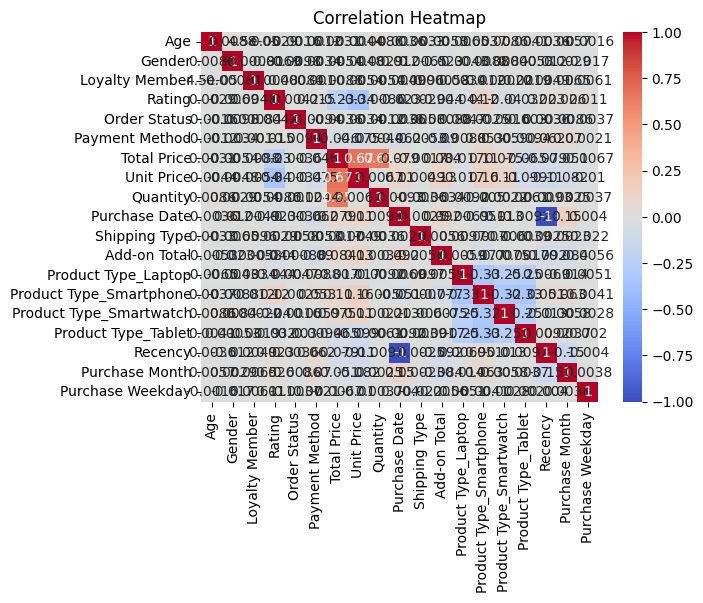

In [ ]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
features = df[['Total Price', 'Quantity', 'Add-on Total', 'Age']]


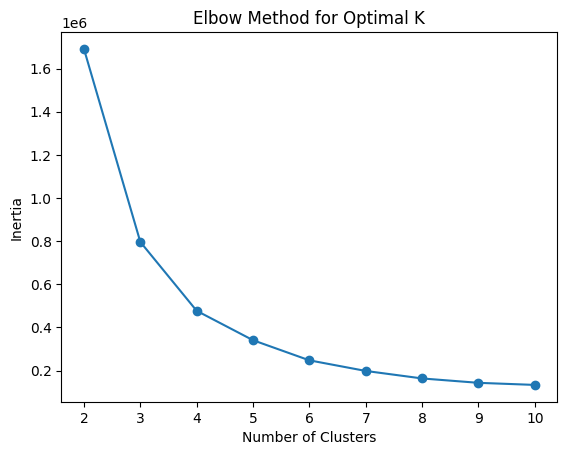

In [ ]:
import matplotlib.pyplot as plt
inertia = []
for k in range(2, 11):  # Trying 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)

silhouette_kmeans_pca = silhouette_score(features_pca, kmeans_labels)
print(f"Silhouette Score for K-Means with PCA: {silhouette_kmeans_pca}")


Silhouette Score for K-Means with PCA: 0.33529997719795945


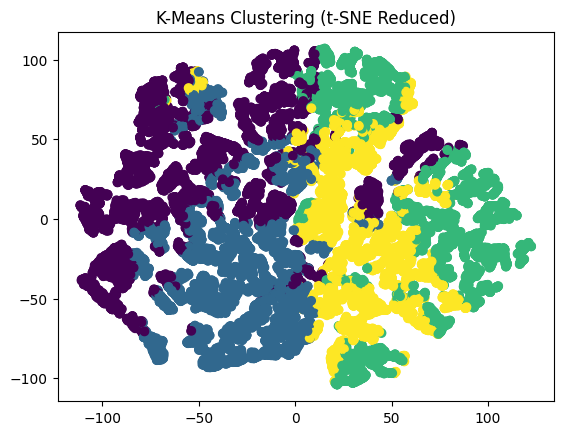

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_scaled)

plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clustering (t-SNE Reduced)')
plt.show()

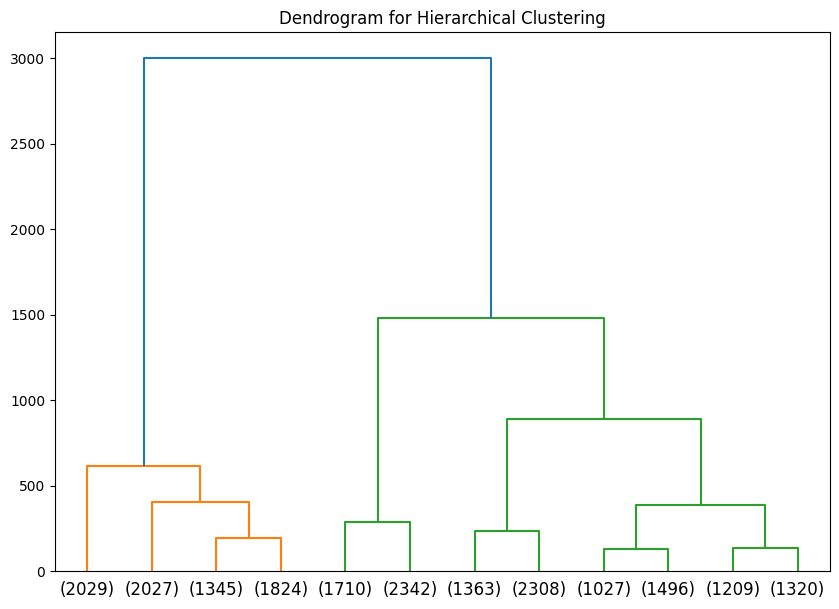

In [ ]:
linked = linkage(features, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=12, show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()

In [ ]:

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(features)
df['DBSCAN_Cluster'] = dbscan_labels
filtered_features = features[dbscan_labels != -1]
filtered_labels = dbscan_labels[dbscan_labels != -1]
if len(set(filtered_labels)) > 1:
    silhouette_dbscan = silhouette_score(filtered_features, filtered_labels)
    print(f"Silhouette Score for DBSCAN (excluding outliers): {silhouette_dbscan}")
else:
    print("Insufficient clusters for silhouette score calculation in DBSCAN.")

Silhouette Score for DBSCAN (excluding outliers): -0.050589086748440266


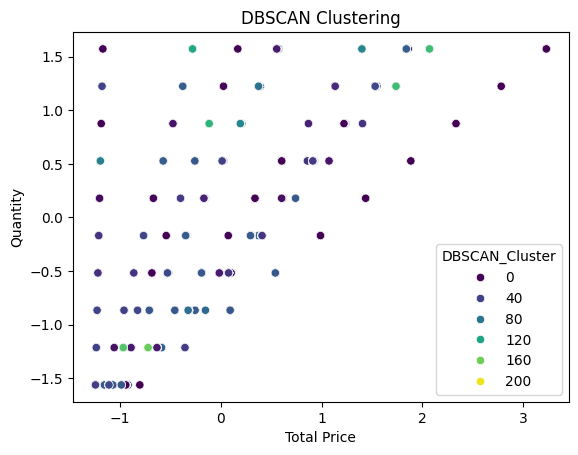

In [ ]:
sns.scatterplot(data=df, x='Total Price', y='Quantity', hue='DBSCAN_Cluster', palette='viridis')
plt.title('DBSCAN Clustering')
plt.show()